In [1]:
import yfinance as yf
import pandas as pd

# Download BTC-USD data
btc = yf.download(["BTC-USD"], start="2021-01-01", end="2024-12-31", interval="1d", auto_adjust=True)
print(btc.head())
btc = btc[["Open", "High", "Low", "Close", "Volume"]].dropna()
print(btc.head())


[*********************100%***********************]  1 of 1 completed

Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2021-01-01  29374.152344  29600.626953  28803.585938  28994.009766   
2021-01-02  32127.267578  33155.117188  29091.181641  29376.455078   
2021-01-03  32782.023438  34608.558594  32052.316406  32129.408203   
2021-01-04  31971.914062  33440.218750  28722.755859  32810.949219   
2021-01-05  33992.429688  34437.589844  30221.187500  31977.041016   

Price            Volume  
Ticker          BTC-USD  
Date                     
2021-01-01  40730301359  
2021-01-02  67865420765  
2021-01-03  78665235202  
2021-01-04  81163475344  
2021-01-05  67547324782  
Price               Open          High           Low         Close  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2021-01-01  28994.009

In [2]:
import numpy as np

# Returns
btc['Return_1d'] = btc['Close'].pct_change()
btc['Return_5d'] = btc['Close'].pct_change(5)

# Momentum Feature: past 5-day return
btc['Momentum_5d'] = btc['Return_5d'].shift(1)

# Reversal Feature: past 1-day return
btc['Reversal_1d'] = -btc['Return_1d'].shift(1)

# Volume Z-Score
btc['Volume_Z'] = (btc['Volume'] - btc['Volume'].rolling(20).mean()) / btc['Volume'].rolling(20).std()

# Drop NAs
btc = btc.dropna()



In [3]:
# Strategy: Buy if past 5-day momentum > 0 and volume is elevated
btc['Signal'] = 0
btc.loc[(btc['Momentum_5d'] > 0) & (btc['Volume_Z'] > 1), 'Signal'] = 1  # long
btc.loc[(btc['Reversal_1d'] > 0) & (btc['Volume_Z'] < -1), 'Signal'] = -1  # short

execution_cost = 0.002  # 20 bps

# Daily strategy return
btc['StrategyReturn'] = btc['Signal'].shift() * btc['Return_1d'] - np.abs(btc['Signal'].diff()) * execution_cost
btc['Cumulative'] = (1 + btc['StrategyReturn']).cumprod()
btc['BuyHold'] = (1 + btc['Return_1d']).cumprod()
print(btc.head())

Price               Open          High           Low         Close  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2021-01-20  36050.113281  36378.328125  33570.476562  35547.750000   
2021-01-21  35549.398438  35552.679688  30250.750000  30825.699219   
2021-01-22  30817.625000  33811.851562  28953.373047  33005.761719   
2021-01-23  32985.757812  33360.976562  31493.160156  32067.642578   
2021-01-24  32064.376953  32944.007812  31106.685547  32289.378906   

Price            Volume Return_1d Return_5d Momentum_5d Reversal_1d  Volume_Z  \
Ticker          BTC-USD                                                         
Date                                                                            
2021-01-20  66834573161 -0.014473 -0.034694   -0.079554    0.015295 -0.206321   
2021-01-21  75643067688 -0.132837 -0.147947   -0.034694    0.014473  0.217022   
2021-01-22  77207272511  0.070722 

Sharpe Ratio: -1.03
Max Drawdown: -76.80%


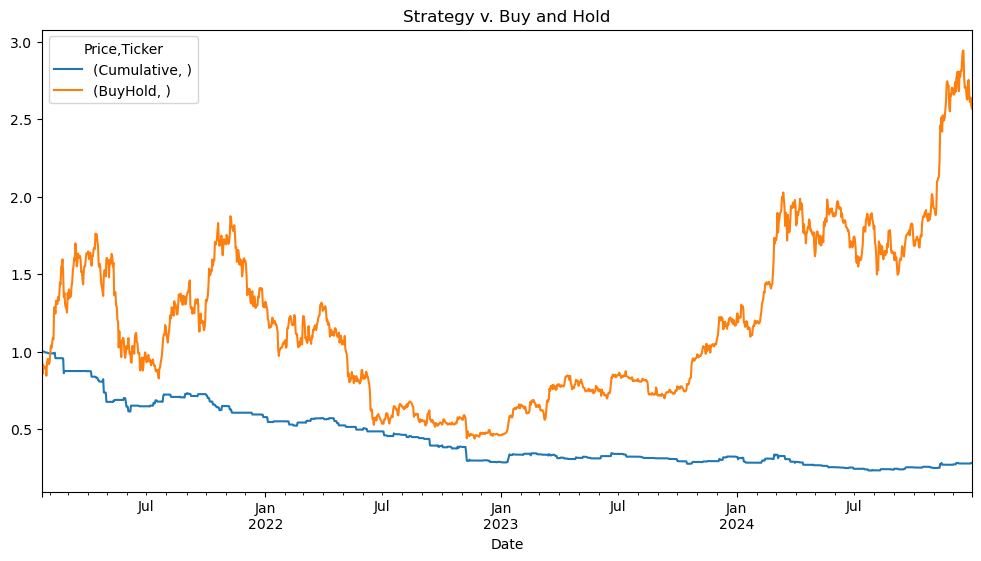

In [4]:
#Evaluate Performance

import matplotlib.pyplot as plt

# Plot
btc[['Cumulative', 'BuyHold']].plot(figsize=(12, 6), title='Strategy v. Buy and Hold')

# Sharpe Ratio
sharpe = btc['StrategyReturn'].mean() / btc['StrategyReturn'].std() * np.sqrt(252)

# Max Drawdown
rolling_max = btc['Cumulative'].cummax()
drawdown = btc['Cumulative'] / rolling_max - 1
max_drawdown = drawdown.min()

print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

<Axes: title={'center': 'Simple vs ML Strategy'}, xlabel='Date'>

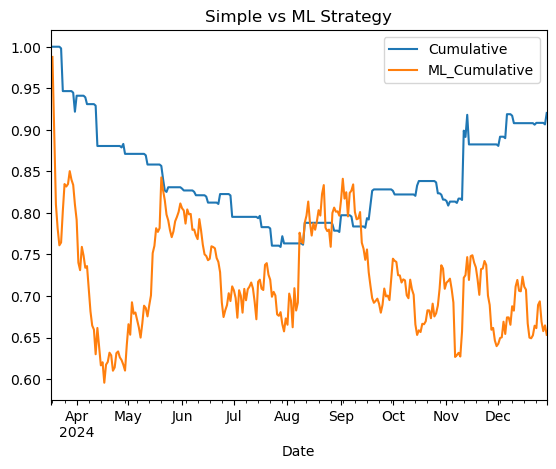

In [5]:
#Train test split to predict future returns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

features = ['Momentum_5d', 'Reversal_1d', 'Volume_Z']
X = btc[features]
X = X.iloc[:-1] #make X match length of y
y = btc['Return_1d'].shift(-1)  # Predict next day's return
y = y.dropna()
#print(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = RandomForestRegressor()
model.fit(X_train, y_train)

btc_test = pd.concat([X_test, y_test.rename('target')], axis=1).dropna()

btc_test['ML_Pred'] = model.predict(X_test)
btc_test['ML_Signal'] = np.where(btc_test['ML_Pred'] > 0, 1, -1)
btc_test['ML_Strategy'] = btc_test['ML_Signal'].shift() * btc.loc[btc_test.index, 'Return_1d'] - np.abs(btc_test['ML_Signal'].diff()) * execution_cost

btc_test['ML_Cumulative'] = (1 + btc_test['ML_Strategy']).cumprod()
btc_test['Cumulative'] = (1 + btc.loc[btc_test.index, 'StrategyReturn']).cumprod()
btc_test[['Cumulative', 'ML_Cumulative']].plot(title='Simple vs ML Strategy')